# VAEVE internship - Data Anlysis - Santiago

## 1. Data extraction
First step is aggroupating all data obtained from DeepEthogram (DEG) analysis and manual annotation. The input is in **DEG format** :
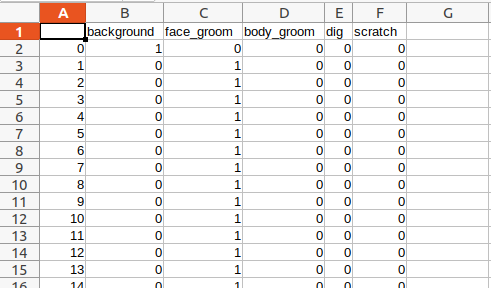

The script charged to do this is "extract_data.py".

In [ ]:
from extract_data import extract
datafile= extract()

## Data transforming
Once the data has been placed on 'behavioural_annotation.csv" by the last cell, we can start by doing the first data extraction and transformation. We are going to define an LBN  session by using the "LbnSession" class. This session will be defined by the **cages**, the **start and end time*.

For this analysis, we'll be exploring all the pups 

In [5]:
from classes.LbnSession import LbnSessions
from datetime import datetime
import pandas as pd
import json
import numpy as np

allCages = pd.read_csv("behavioural_annotation.csv")
allCages["Cage"] = allCages["Cage"].astype(str).str.strip()
allCages = allCages["Cage"].unique().tolist()
allCages = [cage for cage in allCages if cage != "K2"]
print(allCages)
dataFile = r"D:\LBN\behavioural_annotation.csv"

session = LbnSessions(cage=allCages, startDate=datetime(2024,7,5), endDate=datetime(2025,7,6))

['1', '2', '6', '7', 'A', 'C', 'D', 'G']


We extract then some data. First a "resultados.json" file that will contain general information. Then a resumeDf that will contain data by day and not by frames. Indeed, this last dataframe will regroup frame data, into only one line extracting the duration and the frequencie (bouts) of each behaviour. 

In [6]:
# jsonPath = session.exportResults()
resultDf = session.getResumedDf(getCsv=True)


Resume_df.csv


# 2. Data analysis
## Hidden markov model (HMM)
In the context of maternal behavior studies, a Hidden Markov Model (HMM) is a statistical model used to infer unobservable ("hidden") internal behavioral states or motivations of the mother (e.g., nurturing, stressed, exploratory) based on a sequence of observable behaviors, such as "Onnest", "Carryingpups", or "Selfgrooming".

These internal states evolve over time according to a Markov process (i.e., the current state depends only on the previous state), but we cannot observe them directly. Instead, we observe behaviors (the Y process), which are assumed to be probabilistically dependent on the current hidden state (the X process).

The goal of using an HMM here is to:

- Infer latent behavioral states from observed sequences.

- Understand transitions between hidden states across different conditions (e.g., treated vs. control).

- Compare behavior dynamics and transitions that may explain differences in pup development.

Parameter estimation can be done using the Baum–Welch algorithm (an Expectation-Maximization method), which learns the probabilities of transitions between states and the likelihood of each behavior given a state.

### Data transformation
In orrder to have a good input for HMM, we'll need to transform data with 2 possibles combinaison of behaviours : On/off nest and Other behaviuors
The objective is then to have for example : 
- Onnest+Selfgrooming
- Onnest+Eat/drink
- offnest+build
- offnest
- onnest

In [31]:
behavioursTot = ["Onnest", "Offnest", "ABN", "Carryingpups", "Selfgrooming", "Eat_drink", "Kicking", "Groomingpups", "Build", "Nest_entry", "Nest_exits"]

# Assuming session.getSessionDataForPup() returns a DataFrame with the necessary data
df = session.getSessionDataForPup()

# Initialize the new DataFrame for HMM input
hmmDf = pd.DataFrame(columns=["Time", "Behaviour", "Cage", "Condition"])

for idx, row in df.iterrows():
    putt = True
    if row['Onnest'] == 1:
        for behavior in behavioursTot[2:]:  # Skip 'Onnest' and 'Offnest'
            if row[behavior] == 1:
                # Creating a row with Onnest and the specific behavior
                line = pd.Series([row["Time"], f"Onnest+{behavior}", row["Cage"], row["Condition"]], index=hmmDf.columns)
                hmmDf = pd.concat([hmmDf, line.to_frame().T], ignore_index=True)
                putt = False
        if(putt) :
            line = pd.Series([row["Time"], "Onnest", row["Cage"], row["Condition"]], index=hmmDf.columns)
            hmmDf = pd.concat([hmmDf, line.to_frame().T], ignore_index=True)

    # Behavior when Offnest is active
    elif row['Offnest'] == 1:
        for behavior in behavioursTot[2:]:  # Skip 'Onnest' and 'Offnest'
            if row[behavior] == 1:
                # Creating a row with Offnest and the specific behavior
                line = pd.Series([row["Time"], f"Offnest+{behavior}", row["Cage"], row["Condition"]], index=hmmDf.columns)
                hmmDf = pd.concat([hmmDf, line.to_frame().T], ignore_index=True)
            putt = False
        if(putt) :
            line = pd.Series([row["Time"], "Onnest", row["Cage"], row["Condition"]], index=hmmDf.columns)
            hmmDf = pd.concat([hmmDf, line.to_frame().T], ignore_index=True)

print(hmmDf.head())


       Time   Behaviour Cage Condition
0  0.033257  Onnest+ABN    A       LBN
1  0.066515  Onnest+ABN    A       LBN
2  0.099772  Onnest+ABN    A       LBN
3  0.133029  Onnest+ABN    A       LBN
4  0.166286  Onnest+ABN    A       LBN


In [32]:
from sklearn.preprocessing import LabelEncoder
from hmmlearn import hmm
import numpy as np

# Étape 1 : encoder les comportements
le = LabelEncoder()
hmmDf['Behaviour_encoded'] = le.fit_transform(hmmDf['Behaviour'])

# Étape 2 : créer la séquence d'observations (X) et les longueurs par session
# (Ici on suppose que toutes les données viennent d'une seule séquence)
X = hmmDf['Behaviour_encoded'].values.reshape(-1, 1)  # reshape pour hmmlearn
lengths = [len(X)]  # si tu veux faire plusieurs séquences, on adapte ici

# Étape 3 : initialiser et entraîner un HMM
n_states = 5  # choisis le nombre d'états cachés selon ton intuition ou tests
model = hmm.MultinomialHMM(n_components=n_states, n_iter=100, random_state=42)
model.fit(X, lengths)

# Afficher les états cachés prédits pour chaque comportement
hidden_states = model.predict(X)
hmmDf['Hidden_state'] = hidden_states

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


### State probability matrix

In [33]:
print("Matrice de transition (états cachés) :")
print(model.transmat_)

Matrice de transition (états cachés) :
[[8.70151441e-09 9.57991900e-01 4.67909026e-04 6.13749857e-03
  3.54026835e-02]
 [4.49658654e-01 1.11593150e-02 1.03467823e-01 1.66438227e-03
  4.34049826e-01]
 [5.33469414e-07 9.30104465e-01 1.20106772e-03 6.86815374e-02
  1.23965099e-05]
 [2.08310540e-08 5.02686400e-04 1.27469100e-03 2.11558240e-02
  9.77066778e-01]
 [9.34237752e-01 5.89179961e-02 4.18444294e-06 1.45917726e-07
  6.83992132e-03]]


### Behaviour probability for each hidden state

In [34]:
print("Matrice d’émission (états → comportements observés) :")
print(model.emissionprob_)
for i, row in enumerate(model.emissionprob_):
    behaviours = le.inverse_transform(np.arange(len(row)))
    print(f"\nÉtat caché {i}:")
    for b, prob in zip(behaviours, row):
        if prob > 0.01: 
            print(f"  {b} → {prob:.2f}")

print(hmmDf['Behaviour'].unique())

Matrice d’émission (états → comportements observés) :
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]

État caché 0:
  Offnest+Eat_drink → 1.00

État caché 1:
  Offnest+Eat_drink → 1.00

État caché 2:
  Offnest+Eat_drink → 1.00

État caché 3:
  Offnest+Eat_drink → 1.00

État caché 4:
  Offnest+Eat_drink → 1.00
['Onnest+ABN' 'Onnest+Selfgrooming' 'Offnest+Eat_drink'
 'Onnest+Nest_entry' 'Onnest' 'Offnest+Nest_exits' 'Onnest+Build'
 'Onnest+Groomingpups']


### Model adaptation

In [35]:
log_prob = model.score(X)
print(f"Log-vraisemblance de la séquence : {log_prob}")

Log-vraisemblance de la séquence : -7.910450072756703e-12


### visualisation

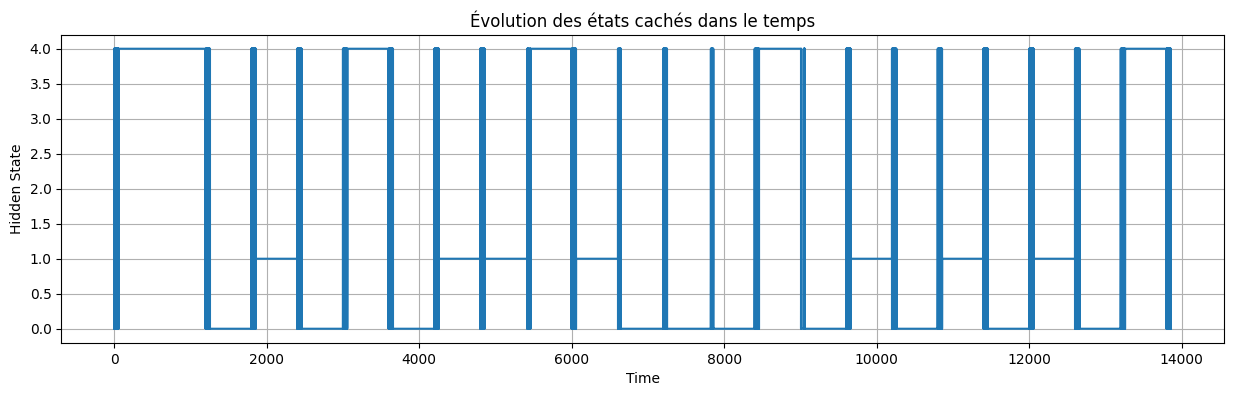

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
plt.plot(hmmDf['Time'], hmmDf['Hidden_state'], drawstyle='steps-post')
plt.xlabel("Time")
plt.ylabel("Hidden State")
plt.title("Évolution des états cachés dans le temps")
plt.grid(True)
plt.show()


## Normal Markov model
The n observed behaviour depends only on previous one (n-1). Higger the probability of passing from an state to another one; higher a cage can be seen as variable and more the behaviours are fragemented

In [37]:
conditions = hmmDf['Condition'].unique()

# Un dictionnaire pour stocker une matrice par condition
transition_matrices = {}

for cond in conditions:
    df_cond = hmmDf[hmmDf['Condition'] == cond]

    # Créer une matrice de transitions vide
    transitions = pd.DataFrame(0, index=behavioursTot, columns=behavioursTot)

    # Remplir la matrice avec les transitions
    for i in range(1, len(df_cond)):
        curr = df_cond.iloc[i-1]['Behaviour']
        next_ = df_cond.iloc[i]['Behaviour']
        if curr in behavioursTot and next_ in behavioursTot:
            transitions.loc[curr, next_] += 1

    # Normalisation ligne par ligne (probabilités)
    for behavior in behavioursTot:
        total = transitions.loc[behavior].sum()
        if total > 0:
            transitions.loc[behavior] /= total

    # Stocker la matrice normalisée
    transition_matrices[cond] = transitions

### Visualisation

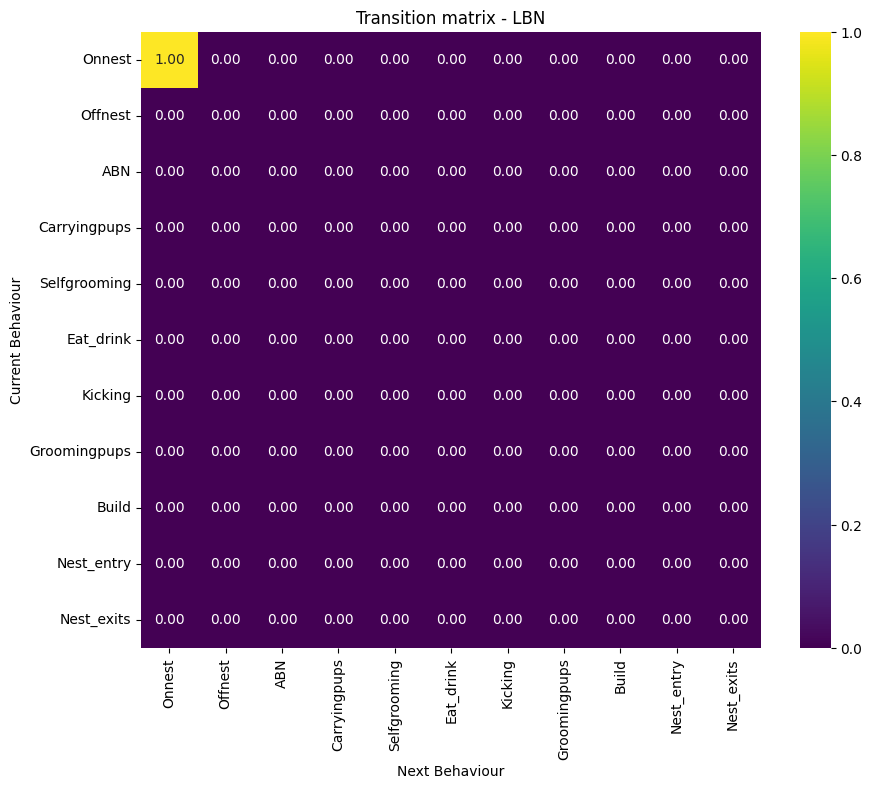

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

for cond, matrix in transition_matrices.items():
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="viridis")
    plt.title(f"Transition matrix - {cond}")
    plt.xlabel("Next Behaviour")
    plt.ylabel("Current Behaviour")
    plt.show()


## Dynamic system

# Transformer - Data prediction
A Transformer is a sequential model based on attention, which does not depend on immediate neighbors (like HMM or Markov models) but can capture relationships between any time positions.

In your context:

| Objective                          | What a Transformer Would Do                                               |
|-----------------------------------|---------------------------------------------------------------------------|
| Identify behavioral routines      | Automatically learns which transitions are frequent or rare, even with delays |
| Compare LBN vs Control sequences  | Learns patterns specific to each condition                                |
| Predict future behaviors          | Generates the next behavior from a past sequence                          |
| Analyze intervention effects      | Visualizes attention weights before/after an intervention                 |


In [39]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# 1. Préparation des données
behaviors = hmmDf['Behaviour'].unique().tolist()
behavior_encoder = LabelEncoder()
hmmDf['Behavior_encoded'] = behavior_encoder.fit_transform(hmmDf['Behaviour'])

condition_encoder = LabelEncoder()
hmmDf['Condition_encoded'] = condition_encoder.fit_transform(hmmDf['Condition'])  # LBN/Control → 0/1

# 2. Séquences groupées par cage
class BehaviorDataset(Dataset):
    def __init__(self, df):
        self.sequences = []
        self.labels = []
        for cage, group in df.groupby('Cage'):
            seq = group.sort_values('Time')['Behavior_encoded'].values
            label = group['Condition_encoded'].iloc[0]
            self.sequences.append(torch.tensor(seq, dtype=torch.long))
            self.labels.append(label)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# 3. Padding & collate
def collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = [len(seq) for seq in sequences]
    padded = nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0)
    return padded, torch.tensor(labels), torch.tensor(lengths)

dataset = BehaviorDataset(hmmDf)
dataloader = DataLoader(dataset, batch_size=4, collate_fn=collate_fn, shuffle=True)

# 4. Modèle Transformer
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=32, nhead=4, num_layers=2, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x, lengths):
        x = self.embedding(x)  # (B, T, D)
        x = x.permute(1, 0, 2)  # Transformer expects (T, B, D)
        x = self.transformer(x)  # Output: (T, B, D)
        x = x[0]  # Take only the first token (CLS-like strategy)
        return self.fc(x)

# 5. Entraînement
model = TransformerClassifier(vocab_size=len(behavior_encoder.classes_))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    for x, y, lengths in dataloader:
        out = model(x, lengths)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

c:\Users\TeamGranon\anaconda3\envs\DEEPLABCUT\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


RuntimeError: [enforce fail at alloc_cpu.cpp:115] data. DefaultCPUAllocator: not enough memory: you tried to allocate 20353016896 bytes.

### Test

In [ ]:
from sklearn.model_selection import train_test_split

# Liste unique de cages
all_cages = hmmDf['Cage'].unique()
train_cages, test_cages = train_test_split(all_cages, test_size=0.3, random_state=42)

train_df = hmmDf[hmmDf['Cage'].isin(train_cages)]
test_df = hmmDf[hmmDf['Cage'].isin(test_cages)]

train_dataset = BehaviorDataset(train_df)
test_dataset = BehaviorDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=4, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, collate_fn=collate_fn, shuffle=False)

model = TransformerClassifier(vocab_size=len(behavior_encoder.classes_))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    model.train()
    total_loss = 0
    for x, y, lengths in train_loader:
        out = model(x, lengths)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_loader):.4f}")

from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for x, y, lengths in test_loader:
        out = model(x, lengths)
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.tolist())
        all_labels.extend(y.tolist())

# Affichage des performances
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=condition_encoder.classes_))
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

### Cross validation

In [ ]:
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader

results = []

for test_cage in hmmDf['Cage'].unique():
    # Split
    train_df = hmmDf[hmmDf['Cage'] != test_cage]
    test_df = hmmDf[hmmDf['Cage'] == test_cage]

    # Datasets and loaders
    train_dataset = BehaviorDataset(train_df)
    test_dataset = BehaviorDataset(test_df)
    train_loader = DataLoader(train_dataset, batch_size=4, collate_fn=collate_fn, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=4, collate_fn=collate_fn)

    # Model reset (re-init à chaque tour)
    model = TransformerClassifier(vocab_size=len(behavior_encoder.classes_))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    # Entraînement rapide (ou plus si tu veux)
    for epoch in range(5):
        model.train()
        for x, y, lengths in train_loader:
            out = model(x, lengths)
            loss = criterion(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Évaluation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y, lengths in test_loader:
            out = model(x, lengths)
            preds = torch.argmax(out, dim=1)
            all_preds.extend(preds.tolist())
            all_labels.extend(y.tolist())

    report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
    results.append(report)

# Moyenne des scores
import numpy as np
final_scores = {}
for label in ['LBN', 'Control']:
    precision = np.mean([r[label]['precision'] for r in results])
    recall = np.mean([r[label]['recall'] for r in results])
    f1 = np.mean([r[label]['f1-score'] for r in results])
    final_scores[label] = {'precision': precision, 'recall': recall, 'f1-score': f1}

print("Cross-validated scores:")
print(final_scores)

# Clusterisation